# Models and Mechanisms for Fairness in Location Data Processing


### Author: Sina Shaham, Gabriel Ghinita, Cyrus Shahabi


### Link to Publication: https://scholar.google.com.au/citations?view_op=view_citation&hl=en&user=WnWN4NkAAAAJ&sortby=pubdate&citation_for_view=WnWN4NkAAAAJ:qxL8FJ1GzNcC


### The following use the NYC taxi dataset for the evaluation of c-fair polynomials in the DtR problem

In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import rand
import time
from scipy.optimize import lsq_linear

from matplotlib import pyplot as plt
%matplotlib inline


### The output scores of the model in addition to DistanceInKM of the datapoints are stored in the following file. 

In [4]:
taxi_fairs = pd.read_csv("SS_NewYork_Predicted_Fairs.csv")

In [5]:
taxi_fairs.head()

,DistanceInKM,PredictedScore
0,0.293514,1.000000
1,8.544000,0.000767
2,2.264298,0.000011
3,5.993536,0.000304
4,0.733875,1.000000


In [8]:
taxi_fairs = taxi_fairs.to_numpy()
DisInKm = taxi_fairs[:,0]
PreScores = taxi_fairs[:,1]

mem = np.max(DisInKm)
DisInKm = DisInKm/mem

### The following calculates the percentage of unfairness in the whole dataset before applying the c-fair polynomials.

In [9]:
UpperLimit = 1000
mem_dis = DisInKm[:UpperLimit]
mem_score = PreScores[:UpperLimit]

diff = []
counter = 0
for i in range(UpperLimit):
    for j in range(i+1,UpperLimit):
        #print(f"here is diff in distance {np.abs(mem_dis[i]- mem_dis[j])}  here is the diff in {np.abs(mem_score[i]- mem_score[j])}")
        if np.abs(mem_score[i]- mem_score[j])>np.abs(mem_dis[i]- mem_dis[j]):
            counter+=1
            diff.append(np.abs(mem_dis[i]- mem_dis[j])- np.abs(mem_score[i]- mem_score[j]))



mem = UpperLimit*(UpperLimit-1)/2

print(f"Total comparison: {mem}  unfair comparisons {counter}")
print(f"unfairness percentage  {(counter/mem)*100}")
diff= np.array(diff)
print(np.average(diff))
print(np.var(diff))


idx_order = np.argsort(mem_dis)
mem_dis = [mem_dis[i] for i in idx_order]
mem_score = [mem_score[i] for i in idx_order]


Total comparison: 499500.0  unfair comparisons 162586
unfairness percentage  32.54974974974975
-0.6801401658323556
0.11409858006344514


# Here is where the main code starts

In [13]:
import random
def Cal_error(p):
    counter = 0
    tot = 100000
    for i in range(tot):
        n1 = random.uniform(0, 1)
        n2 = random.uniform(0, 1)


        if np.abs(p([n1][0])-p([n2][0])) > np.abs(n1-n2)+0.000001:
            counter+=1
    print(f'percentage of error {(counter/tot)*100}')

    return (counter/tot)*100


#These are time, iteration and final cost 
computation_complexity = []


# RMS is the key list holding calculated values 
RMS = []
for n in [5,10,15,20]:   
    
    b = mem_score

    #Create A here
    A= []
    for i in range(UpperLimit): 
        mem=[]


        for j in range(n+1):
            if j==0:
                #pass
                mem.append(1)
            else:
                mem.append(mem_dis[i]**j)

        A.append(mem)

    A = np.array(A)

    computation_complexity_mem = []
    RMS_mem = []
    for c in [25,50,75,100]:
        
        start_time = time.time()
        
        ub = []
        ub = [np.inf]
        for i in range(1,n+1):
            ub.append(6*i*c/(n*(n+1)*(2*n+1)))
        ub = np.array(ub)
        lb = -ub
        
        print(f'The n value is {n} the c value is {c}')
        res = lsq_linear(A, b, bounds=(lb, ub), lsmr_tol='auto', verbose=1)
       
        

        x = mem_dis
        y = mem_score
        coefficients = res.x[::-1]
        #print(coefficients)
        p = np.poly1d(coefficients)
        new_x = np.linspace(x[0], x[-1])
        new_y =p(new_x)
        end_time = time.time()
        RMS_mem.append(   [c, np.sqrt(np.mean((p(x)-y)**2)), Cal_error(p)]   )
        computation_complexity_mem.append([c, end_time-start_time, res.cost, res.nit])
        
        
    RMS.append(RMS_mem)
    computation_complexity.append(computation_complexity_mem)

The n value is 5 the c value is 25
The first-order optimality measure is less than `tol`.
Number of iterations 9, initial cost 6.1983e+02, final cost 5.3182e+01, first-order optimality 7.46e-14.
percentage of error 11.789
The n value is 5 the c value is 50
The relative change of the cost function is less than `tol`.
Number of iterations 11, initial cost 6.8725e+02, final cost 5.0160e+01, first-order optimality 3.77e-10.
percentage of error 11.384
The n value is 5 the c value is 75
The first-order optimality measure is less than `tol`.
Number of iterations 8, initial cost 5.9993e+02, final cost 4.8153e+01, first-order optimality 4.36e-11.
percentage of error 23.233999999999998
The n value is 5 the c value is 100
The first-order optimality measure is less than `tol`.
Number of iterations 12, initial cost 1.2700e+03, final cost 4.6500e+01, first-order optimality 1.13e-11.
percentage of error 36.201
The n value is 10 the c value is 25
The first-order optimality measure is less than `tol`.



# Percentage of Unfairness VS c

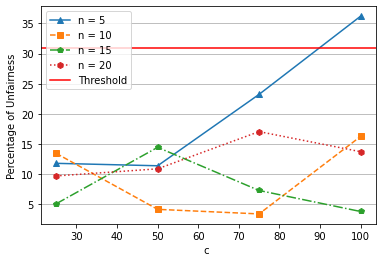

In [18]:

#RSM_mem for each n stores [c, fitting error(rms), percentage of unfairness]


#Let us start by plotting percentage of error w.r.t. c for various n
fig, axs = plt.subplots(1,figsize=(6,4))
markers=['^', 's', 'p', 'h', '8']
lines = ["-","--","-.",":"]
for idx,i in enumerate(RMS):
    c_array = [i[j][0] for j in range(len(i))]
    PoE_array = [i[j][2] for j in range(len(i))]
    axs.plot(c_array,PoE_array, marker=markers[idx], linestyle=lines[idx], label = f'n = {(idx+1)*5}')
    #axs[0].set_xscale('log')
    axs.set_xlabel(' c  ')
    axs.set_ylabel('Percentage of Unfairness')
    
    
axs.grid(axis = 'y')
axs.axhline(y=31, color='r', linestyle='-',label  = 'Threshold')
axs.legend()
    #axs[idx].set_yscale('log')
#axs[idx].set_title(f" Degree of Fair-Polynomial: n = {idx+1}");
    
fig.savefig("NewYork_PoE_vs_c_Paper.pdf", bbox_inches='tight')

# Percentage of Unfairness VS n

<ipython-input-32-6813f2c4e100>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels([0,5,7.5,10,12.5,15,17.5,20])


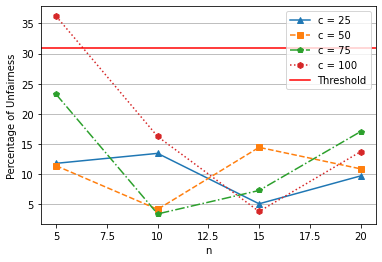

In [32]:
#Let us start by plotting fitting error w.r.t. n for various c
# The plot in the paper follows higher number of n values; Run the main code with wider range for n
c_array = [i[0] for i in RMS[0]]

fig, axs = plt.subplots(1,figsize=(6,4))



markers=['^', 's', 'p', 'h', '8']
lines = ["-","--","-.",":"]



for idx,c in enumerate(c_array):
    
    PoE_array =  [i[idx][2] for i in RMS]
    n_array = [int(2*j) for j in range(1,len(RMS)+1)]
    axs.plot(n_array,PoE_array,marker=markers[idx], linestyle=lines[idx], label = f'c = {(idx+1)*25}')
    #axs[idx].set_xscale('log')
    axs.set_xlabel('n')
    axs.set_ylabel('Percentage of Unfairness')
    #axs.set_yscale('log')
    #axs.set_title(f" c = {c}");
axs.grid(axis = 'y')

#axs.set_yticklabels([i for i in range(20,110,20)])
#axs.set_xticklabels([i for i in range(0,22,5)])
axs.set_xticklabels([0,5,7.5,10,12.5,15,17.5,20])
axs.axhline(y=31, color='r', linestyle='-',label  = 'Threshold')
axs.legend()

fig.savefig("NewYork_PoE_vs_n_Paper.pdf", bbox_inches='tight')

# FittingError vs n

<ipython-input-35-1e562bc90a75>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels([0,5,7.5,10,12.5,15,17.5,20])


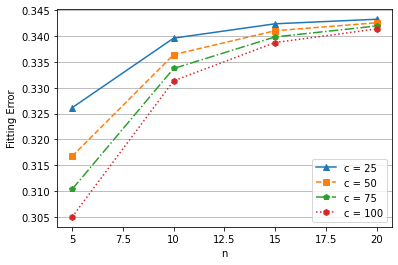

In [35]:
c_array = [i[0] for i in RMS[0]]
fig, axs = plt.subplots(1,figsize=(6,4))
markers=['^', 's', 'p', 'h', '8']
lines = ["-","--","-.",":"]

for idx,c in enumerate(c_array):
    fitting_error =  [i[idx][1] for i in RMS]
    n_array = [int(j) for j in range(1,len(RMS)+1)]    
    axs.plot(n_array,fitting_error,marker=markers[idx], linestyle=lines[idx], label = f'c = {(idx+1)*25}')
    

    #axs[idx].set_xscale('log')
    axs.set_xlabel('n')
    axs.set_ylabel('Fitting Error')
    #axs[idx].set_yscale('log')
    #axs[idx].set_title(f" c = {c}");

axs.grid(axis = 'y')                       
axs.set_xticklabels([0,5,7.5,10,12.5,15,17.5,20])
axs.legend()
                        
#fig.savefig("NewYork_FittingError_vs_n_Paper.pdf", bbox_inches='tight')





# Fitting Error VS c

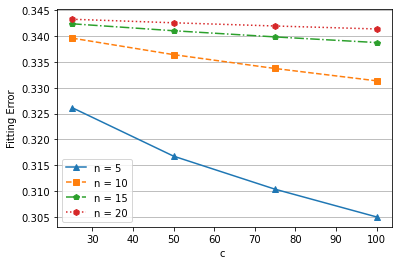

In [37]:

fig, axs = plt.subplots(1,figsize=(6,4))
markers=['^', 's', 'p', 'h', '8']
lines = ["-","--","-.",":"]


for idx,i in enumerate(RMS):
    c_array = [i[j][0] for j in range(len(i))]
    fitting_error =  [i[j][1] for j in range(len(i))]
    axs.plot(c_array,fitting_error, marker=markers[idx], linestyle=lines[idx], label = f'n = {(idx+1)*5}')    
    #axs.set_xscale('log')
    axs.set_xlabel('c ')
    axs.set_ylabel('Fitting Error')
    #axs.set_yscale('log')
    #axs.set_title(f" n = {idx+1}");
    
#fig.savefig("FittingError_vs_c.pdf", bbox_inches='tight')
axs.grid(axis = 'y')
axs.legend()

#fig.savefig("NewYork_FittingError_vs_c_Paper.pdf", bbox_inches='tight')